# Turning drone data into training data

Welcome to part 1 of our MAMBO "Deep Learning with drone data" workshop!

We've got a collection of **polygons** that describe shrub canopies in a shapefile, and some aerial **imagery** captured by a drone covering the same region.

We're going to turn those datasets into **training data** that a deep learning model can use to identify shrubs from aerial imagery.

## Setting up

Install the software packages we need to work with geospatial data, some functions to make it easier, via the [shrub-prepro](https://github.com/MAMBO-Horizon-WP4/shrub-prepro) repository.


In [ ]:
%pip install git+https://github.com/MAMBO-Horizon-WP4/shrub-prepro

  Cloning https://github.com/MAMBO-Horizon-WP4/shrub-prepro to /tmp/pip-req-build-d_dvf9iq
  Running command git clone --filter=blob:none --quiet https://github.com/MAMBO-Horizon-WP4/shrub-prepro /tmp/pip-req-build-d_dvf9iq
  Resolved https://github.com/MAMBO-Horizon-WP4/shrub-prepro to commit 4fbb5a891e7a9b88bfbb3cd93c6f17182e0e047a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 73.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.0/201.0 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 77.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 kB 5.2 MB/s eta 0:00:00
  Created wheel for shrub-prepro: filename=shrub_prepro-0.2.0-py3-none-any.whl size=21419 sha256=1eb5cc11e694598b54e02563900f31f8c4145

Next `import` the packages we'll use to process and preview data:

In [ ]:
import os
import s3fs
import rasterio
import geopandas as gpd
from rasterio.windows import Window
from shapely.geometry import shape, box
from pathlib import Path
from rasterio.plot import show
from rasterio.features import rasterize
import numpy as np
from tqdm import tqdm

Set our connnection details for reading the data from cloud storage - in s3, kindly provided by JASMIN.

In [ ]:
import os
os.environ['AWS_S3_ENDPOINT'] = 'ukcehdrs-o.s3-ext.jc.rl.ac.uk'
os.environ['AWS_ENDPOINT_URL'] = 'https://ukcehdrs-o.s3-ext.jc.rl.ac.uk'
os.environ['AWS_VIRTUAL_HOSTING']="False"
os.environ['AWS_HTTPS']="True"
os.environ['AWS_NO_SIGN_REQUEST'] = "True"
os.environ['AWS_SECRET_ACCESS_KEY'] = ""

s3 = s3fs.S3FileSystem(anon=True)

## Explore the source data

These are the files we'll be working with - a shapefile of polygons, and the RGB Structure from Motion image

In [ ]:
raster_source = 's3://shrub-prepro/input/Strawberry_labelled_area_COG.tif'
vector_source = 's3://shrub-prepro/input/reprojected_yellow_low_shrub.zip'

Our shrub polygons are held in a shapefile; let's open it up using [Geopandas](https://geopandas.org/en/stable/) and have a look at the plot

<Axes: >

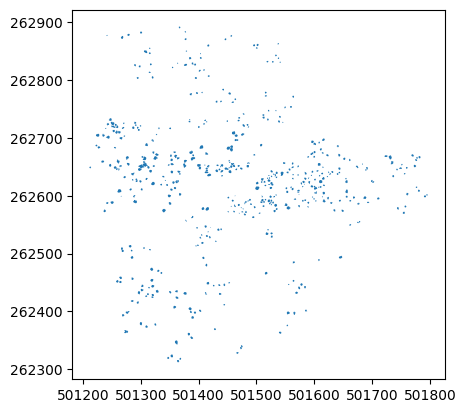

In [ ]:
shrubs = gpd.read_file(vector_source)
shrubs.plot()

We can preview the first few rows in the table with `head()`

In [ ]:
five_rows = shrubs.head()
five_rows

,id,area,geometry
0,1.0,1,"POLYGON ((501491.028 262586.114, 501491.302 26..."
1,1.0,1,"POLYGON ((501485.916 262592.442, 501486.586 26..."
2,1.0,1,"POLYGON ((501487.955 262594.572, 501488.685 26..."
3,NaN,1,"POLYGON ((501481.139 262591.256, 501481.778 26..."
4,NaN,1,"POLYGON ((501469.882 262586.022, 501471.403 26..."


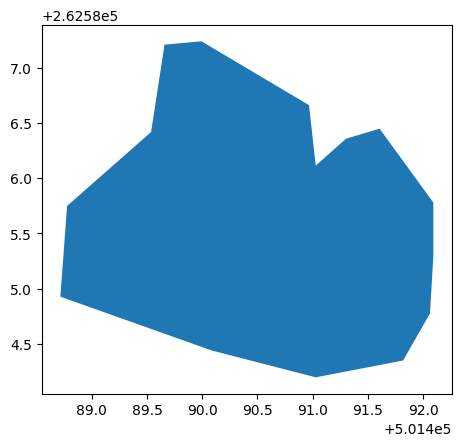

In [ ]:
first_row = shrubs.head(1)
first_row.plot();

Our high-resolution raster image covering the same area as the polygon labels is large - over 10Gb in size.

We've published it as a **Cloud Optimised GeoTIFF**, to make reading small amounts of it quicker.

We can see a preview of the whole area by asking for "overviews" - this shows the smallest one.

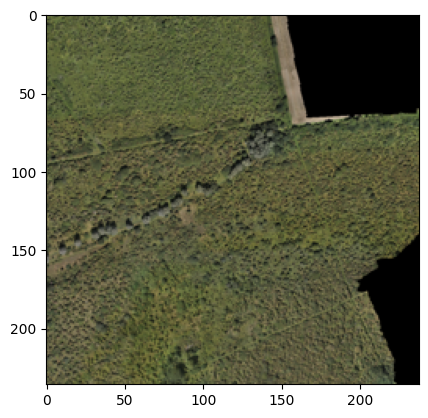

In [ ]:
with rasterio.open(raster_source) as src:
    overview = src.overviews(1)[-1] #
    thumbnail = src.read(out_shape=(3, int(src. height // overview), int(src. width // overview)))
    show(thumbnail)

Rather than try to read all 10Gb of the file at once, we'll build up our training data by reading small windows from it, framed by the shrub polygons.

In [ ]:
image = rasterio.open(raster_source)

We can see its extent by looking at its metadata

In [ ]:
print(image.bounds)
print(f"Image width: {image.width} pixels")
print(f"Image height: {image.height} pixels")

BoundingBox(left=501210.0, bottom=262311.0, right=501796.0, top=262892.0)
Image width: 61345 pixels
Image height: 60822 pixels


### Read a window

We can use a Window to read a small area from the much larger image in a quicker way.

We **define a function** to do this. Our function will create a window of a given size around a polygon.

* Find the centre of the polygon, in coordinates
* Use `image.index` to convert the coordinates to a pixel location in the image
* Use that pixel location as the centre of a window, in this case 256 x 256 pixels in size

Assumes that the image and the shapefile use the same projection!

In [ ]:
def patch_window(geom: gpd.geoseries.GeoSeries, image: rasterio.DatasetReader, patch_size: int = 256) -> rasterio.windows.Window:
    """
    """
    half_patch = patch_size // 2

    center_x, center_y = geom.centroid.x, geom.centroid.y
    row_col = image.index(center_x, center_y)

    window = Window(
          row_col[1] - half_patch, row_col[0] - half_patch, patch_size, patch_size
    )
    return window

Now we use that function to find that window within the image, and read from it

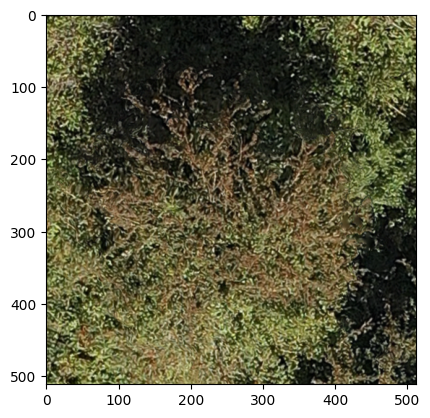

<Axes: >

In [ ]:
window = patch_window(first_row, image, 512)
image_patch = image.read(window=window)

show(image_patch)


### Create a label for the same window

We want to make sure that each of our label patches includes information about all the shrubs contained in it, not just the central one.

In [ ]:
def shrub_labels_in_window(geometries: gpd.GeoSeries, window: rasterio.windows.Window, image: rasterio.DatasetReader) -> gpd.GeoSeries:
    """
    Works out the intersection between all the shrubs and a window within the image.
    """
    transform = rasterio.windows.transform(window, image.transform)
    bounds = rasterio.windows.bounds(window, image.transform)
    bbox = box(*bounds)
    s = geometries.intersection(bbox)
    out_series = s[~(s.is_empty)]
    return out_series


<Axes: >

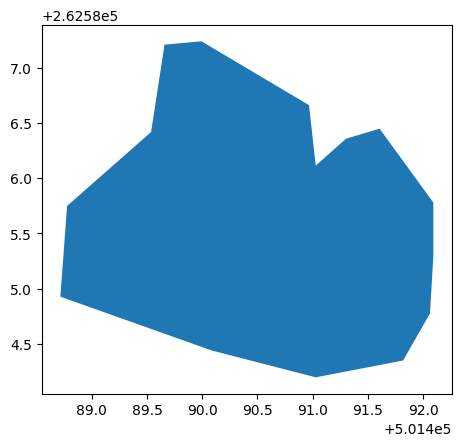

In [ ]:
shrub_labels_in_window(shrubs, window, image).plot()

For our training data, we want to show the model two sets of inputs.

* An example image
* A label for each pixel in the image, showing where our objects of interest are and where they aren't.

In this case our labels are _binary_, e.g. areas of the image are either shrubs, or they're not.

This function uses our image and window to create a matching label for our image patch.

* First `transform` our pixel coordinates back into geographic coordinates
* Then `rasterize` the polygons that outline our shrub

In [ ]:
def label_patch_with_window(geoms: gpd.GeoSeries, window: rasterio.windows.Window, image: rasterio.DatasetReader) -> None:
    transform = rasterio.windows.transform(window, image.transform)
    arr = rasterize(geoms.geometry,
                    out_shape=(int(window.height), int(window.width)),
                    transform=transform,
                    default_value=255)
    return arr

Let's call the function with the first row in our shapefile, and have a look at it:

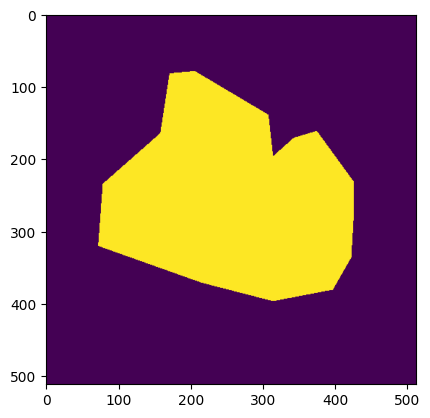

<Axes: >

In [ ]:
labels = shrub_labels_in_window(shrubs, window, image)
arr = label_patch_with_window(labels, window, image)
show(arr)

This is a _single band_ image in which each pixel has one of two values.

By default, `rasterize` would make that 0 and 1, but if we save that as a greyscale image then the colours are impossible for the human eye to distinguish.

So we use the value 255 for our shrub pixels, which makes them appear white in the saved image.

In [ ]:
np.unique(arr)

array([  0, 255])

### Negative example with a blank label

When we create our training data, we're also going to create a set of **negative examples**. This will help the model to learn what shrub canopies look like by showing it what they _don't_ look like.

We do this by picking a number of random points in the area covered by our labelled polygons, checking that there's no intersecting shrub outline there, and creating a label that's all zeros.


In [ ]:
label_arr = np.zeros((256, 256), dtype=np.uint8) # Use uint8 for labels (0 or 1/255)

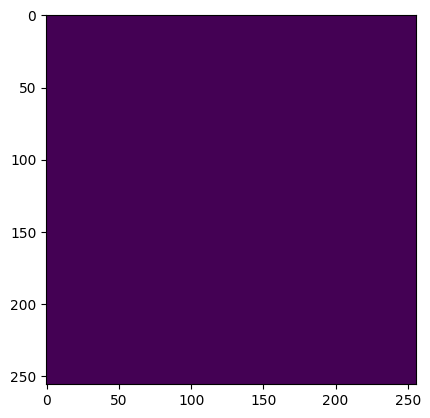

<Axes: >

In [ ]:
show(label_arr)

## Write out our images and labels

Create a new directory to save our data into, in "labels" and "images" directories.

We really recommend saving the images to your Google Drive! Otherwise when we disconnect from this notebook session, they will disappear.

![mount drive from Colab image](https://i.sstatic.net/Rj69d.png)

Once you've connected your Google Drive (with `Files` ... `Mount Drive`) we'll create a directory to hold our training data


In [ ]:
output_dir='/content/drive/MyDrive/mambo_data/shrub_training_data'
os.makedirs(output_dir, exist_ok=True)

## Write the whole training dataset

And now run the code across the whole collection of shrub polygons! In sequence this does:

* Draw a 256*256 pixel window around each shrub
* Find the intersections of any other shrubs with that window
* If the shrub entirely fills the window, create several overlapping ones so the model can be shown the whole outline
* Create a binary image for each window, with each pixel labelled 0 or 255
* Read the RGB data from the image within that window

Once that completes, we

* Pick a set of random windows that don't contain a shrub, and save them with labels of all zero

Rather than define each of these functions in a notebook cell, we can import them from the [shrub-prepro](https://github.com/MAMBO-Horizon-WP4/shrub-prepro/) package that we installed right at the start of this notebook. You can [read the code in detail here](https://github.com/MAMBO-Horizon-WP4/shrub-prepro/blob/4fbb5a891e7a9b88bfbb3cd93c6f17182e0e047a/src/shrub_prepro/processing.py#L23) if you'd like.

This could take up to 15 minutes to run in Colab. Please keep the tab with this notebook open while we return to group discussion.

In [ ]:
from shrub_prepro.processing import process_data

process_data(raster_source,
             vector_source,
             output_dir,
             'shrubs',
             window_size=256)

Shrub images and labels:   0%|          | 0/496 [00:00<?, ?it/s]

318.520725466311 353.5555550381541


Shrub images and labels:   0%|          | 1/496 [00:05<42:25,  5.14s/it]

248.44616563618183 264.3703700006008


Shrub images and labels:   0%|          | 2/496 [00:06<24:26,  2.97s/it]

359.9284197278321 401.33333273231983


Shrub images and labels:   1%|          | 3/496 [00:07<18:16,  2.22s/it]

617.9302075654268 474.5925919264555


Shrub images and labels:   1%|          | 4/496 [00:08<14:29,  1.77s/it]

398.15090676024556 382.22222167253494


Shrub images and labels:   1%|          | 5/496 [00:09<12:10,  1.49s/it]

452.2994301505387 356.74074022471905


Shrub images and labels:   1%|          | 6/496 [00:12<13:39,  1.67s/it]

181.55681325867772 203.85185156017542


Shrub images and labels:   1%|▏         | 7/496 [00:12<10:43,  1.32s/it]

165.63077733665705 257.99999964237213


Shrub images and labels:   2%|▏         | 8/496 [00:15<14:28,  1.78s/it]

308.9651037864387 318.5185180604458


Shrub images and labels:   2%|▏         | 9/496 [00:17<14:05,  1.74s/it]

191.11243531107903 197.4814811721444


Shrub images and labels:   2%|▏         | 10/496 [00:17<11:21,  1.40s/it]

356.74321249872446 388.59259206801653


Shrub images and labels:   2%|▏         | 11/496 [00:18<09:34,  1.18s/it]

130.59349753707647 165.62962938845158


Shrub images and labels:   2%|▏         | 12/496 [00:18<08:07,  1.01s/it]

359.9284197278321 334.4444439485669


Shrub images and labels:   3%|▎         | 13/496 [00:20<10:33,  1.31s/it]

434.3204501569271 427.07881661504507


Shrub images and labels:   3%|▎         | 14/496 [00:22<09:55,  1.23s/it]

331.12507344037294 412.2140716984868


Shrub images and labels:   3%|▎         | 15/496 [00:23<09:21,  1.17s/it]

314.2309373654425 361.5320136845112


Shrub images and labels:   3%|▎         | 16/496 [00:24<11:12,  1.40s/it]

361.5345194004476 405.45646397024393


Shrub images and labels:   3%|▎         | 17/496 [00:27<12:42,  1.59s/it]

273.6850099079311 341.259190492332


Shrub images and labels:   4%|▎         | 18/496 [00:27<11:12,  1.41s/it]

398.70161927863955 314.22875958681107


Shrub images and labels:   4%|▍         | 19/496 [00:29<10:22,  1.31s/it]

278.5609347447753 270.60017517209053


Shrub images and labels:   4%|▍         | 20/496 [00:30<10:01,  1.26s/it]

326.3142371252179 338.2502189427614


Shrub images and labels:   4%|▍         | 21/496 [00:30<08:08,  1.03s/it]

310.39646949619055 270.6001751497388


Shrub images and labels:   4%|▍         | 22/496 [00:31<08:22,  1.06s/it]

409.8825175128877 342.2296332716942


Shrub images and labels:   5%|▍         | 23/496 [00:33<10:25,  1.32s/it]

270.60205025598407 298.45607555657625


Shrub images and labels:   5%|▍         | 24/496 [00:34<09:44,  1.24s/it]

230.8076310865581 274.5795894935727


Shrub images and labels:   5%|▌         | 25/496 [00:37<12:10,  1.55s/it]

134.20152682811022 286.91162045300007


Shrub images and labels:   5%|▌         | 26/496 [00:37<10:03,  1.28s/it]

471.66860270500183 507.94728253781796


Shrub images and labels:   5%|▌         | 27/496 [00:39<10:00,  1.28s/it]

275.74472173675895 341.0503182709217


Shrub images and labels:   6%|▌         | 28/496 [00:40<10:12,  1.31s/it]

181.41100096702576 341.0503182411194


Shrub images and labels:   6%|▌         | 29/496 [00:42<11:50,  1.52s/it]

420.87352227419615 515.2036722972989


Shrub images and labels:   6%|▌         | 30/496 [00:44<12:58,  1.67s/it]

297.51404141262174 282.99920027703047


Shrub images and labels:   6%|▋         | 31/496 [00:46<13:35,  1.75s/it]

348.3091218546033 341.0503182634711


Shrub images and labels:   6%|▋         | 32/496 [00:47<11:33,  1.49s/it]

304.7704817466438 319.28114900738


Shrub images and labels:   7%|▋         | 33/496 [00:49<12:46,  1.66s/it]

442.6428424678743 413.6142157763243


Shrub images and labels:   7%|▋         | 34/496 [00:50<12:48,  1.66s/it]

384.5913218408823 442.6397747695446


Shrub images and labels:   7%|▋         | 36/496 [00:51<07:50,  1.02s/it]

343.10804910212755 500.1201308220625
505.93898751959205 459.41267831623554


Shrub images and labels:   7%|▋         | 37/496 [00:53<09:49,  1.28s/it]

657.1391443498433 750.1801962256432


Shrub images and labels:   8%|▊         | 38/496 [00:55<11:22,  1.49s/it]

176.61690201982856 225.18498938530684


Shrub images and labels:   8%|▊         | 39/496 [00:56<09:12,  1.21s/it]

329.06119852513075 272.4077489003539


Shrub images and labels:   8%|▊         | 40/496 [00:58<10:29,  1.38s/it]

444.5163020826876 424.9741788059473


Shrub images and labels:   8%|▊         | 41/496 [01:00<11:46,  1.55s/it]

434.74671298637986 371.24181135743856


Shrub images and labels:   8%|▊         | 42/496 [01:01<10:23,  1.37s/it]

263.7789047397673 151.4275809302926


Shrub images and labels:   9%|▉         | 44/496 [01:01<06:21,  1.19it/s]

478.7098637409508 278.43135853111744
239.35493202134967 229.58375177532434


Shrub images and labels:   9%|▉         | 45/496 [01:02<05:37,  1.34it/s]

234.47013739868999 210.044709071517


Shrub images and labels:   9%|▉         | 46/496 [01:02<05:02,  1.49it/s]

353.3916619680822 317.32908918708563


Shrub images and labels:   9%|▉         | 47/496 [01:04<06:24,  1.17it/s]

446.869199346751 546.8229940757155


Shrub images and labels:  10%|▉         | 48/496 [01:05<08:23,  1.12s/it]

458.62891524657607 702.6381482928991


Shrub images and labels:  10%|▉         | 49/496 [01:07<10:13,  1.37s/it]

226.37452862784266 170.51469708234072


Shrub images and labels:  10%|█         | 50/496 [01:08<07:57,  1.07s/it]

216.90422622859478 347.68230579793453


Shrub images and labels:  10%|█         | 51/496 [01:10<09:55,  1.34s/it]

551.5346629619598 503.2718920558691


Shrub images and labels:  10%|█         | 52/496 [01:11<09:17,  1.26s/it]

550.9319964051247 487.2530623450875


Shrub images and labels:  11%|█         | 53/496 [01:12<09:53,  1.34s/it]

487.25643886625767 722.5741435959935


Shrub images and labels:  11%|█         | 54/496 [01:14<11:08,  1.51s/it]

289.2864761352539 427.4501892402768


Shrub images and labels:  11%|█         | 55/496 [01:16<12:04,  1.64s/it]

354.05210530757904 690.8285885974765


Shrub images and labels:  11%|█▏        | 56/496 [01:17<09:31,  1.30s/it]

483.58336328715086 466.30929731577635


Shrub images and labels:  11%|█▏        | 57/496 [01:18<10:37,  1.45s/it]

371.32293966412544 418.8148318231106


Shrub images and labels:  12%|█▏        | 58/496 [01:19<08:29,  1.16s/it]

280.09490981698036 375.03973760455847


Shrub images and labels:  12%|█▏        | 59/496 [01:20<08:06,  1.11s/it]

227.8738247975707 142.42015350610018


Shrub images and labels:  12%|█▏        | 60/496 [01:20<06:51,  1.06it/s]

460.4950206503272 469.9865066036582


Shrub images and labels:  12%|█▏        | 61/496 [01:21<06:52,  1.05it/s]

410.48191007971764 614.283356808126


Shrub images and labels:  12%|█▎        | 62/496 [01:22<06:58,  1.04it/s]

353.07185301184654 364.55133793503046


Shrub images and labels:  13%|█▎        | 63/496 [01:23<07:15,  1.00s/it]

358.81285821273923 364.55133790522814


Shrub images and labels:  13%|█▎        | 64/496 [01:25<09:12,  1.28s/it]

413.6589000225067 432.8958486020565


Shrub images and labels:  13%|█▎        | 65/496 [01:26<07:52,  1.10s/it]

439.31216495484114 426.48257675021887


Shrub images and labels:  13%|█▎        | 66/496 [01:28<09:33,  1.33s/it]

262.94596718624234 532.3015619665384


Shrub images and labels:  14%|█▎        | 67/496 [01:29<08:07,  1.14s/it]

509.4431864283979 385.3694812133908


Shrub images and labels:  14%|█▎        | 68/496 [01:29<07:34,  1.06s/it]

423.99514247104526 485.2355226650834


Shrub images and labels:  14%|█▍        | 69/496 [01:31<09:22,  1.32s/it]

190.05601866170764 314.7780991792679


Shrub images and labels:  14%|█▍        | 70/496 [01:33<10:02,  1.41s/it]

285.0840277373791 234.5987720116973


Shrub images and labels:  14%|█▍        | 71/496 [01:34<09:38,  1.36s/it]

766.7009387686849 591.1164746955037


Shrub images and labels:  15%|█▍        | 72/496 [01:36<10:39,  1.51s/it]

427.24556126073 368.71621688455343


Shrub images and labels:  15%|█▍        | 73/496 [01:37<08:52,  1.26s/it]

321.8973410129547 351.15830183029175


Shrub images and labels:  15%|█▍        | 74/496 [01:38<08:19,  1.18s/it]

386.23694766685367 252.53779247403145


Shrub images and labels:  15%|█▌        | 75/496 [01:40<09:40,  1.38s/it]

336.7193902246654 514.9790277704597


Shrub images and labels:  15%|█▌        | 76/496 [01:42<10:47,  1.54s/it]

415.94748178869486 297.10328524559736


Shrub images and labels:  16%|█▌        | 77/496 [01:44<12:05,  1.73s/it]

361.47816916927695 495.1721420958638


Shrub images and labels:  16%|█▌        | 78/496 [01:46<13:28,  1.93s/it]

239.20582587644458 277.78548557311296


Shrub images and labels:  16%|█▌        | 79/496 [01:48<12:59,  1.87s/it]

250.78030111268163 262.35295859724283


Shrub images and labels:  16%|█▌        | 80/496 [01:50<12:30,  1.80s/it]

300.9363618083298 281.64361733943224


Shrub images and labels:  16%|█▋        | 81/496 [01:51<12:11,  1.76s/it]

411.1366784609854 429.82173039764166


Shrub images and labels:  17%|█▋        | 82/496 [01:53<12:35,  1.83s/it]

498.3474890179932 386.2166273370385


Shrub images and labels:  17%|█▋        | 83/496 [01:55<12:57,  1.88s/it]

453.78017080947757 538.6943640708923


Shrub images and labels:  17%|█▋        | 84/496 [01:56<11:03,  1.61s/it]

175.14322397485375 167.18100952357054


Shrub images and labels:  17%|█▋        | 85/496 [01:57<08:33,  1.25s/it]

197.03826446831226 223.71001629531384


Shrub images and labels:  17%|█▋        | 86/496 [01:57<07:02,  1.03s/it]

425.49847526848316 346.70005851238966


Shrub images and labels:  18%|█▊        | 87/496 [01:59<08:29,  1.25s/it]

225.8819064423442 267.90459065139294


Shrub images and labels:  18%|█▊        | 88/496 [02:00<07:32,  1.11s/it]

556.8251652307808 309.92884016782045


Shrub images and labels:  18%|█▊        | 89/496 [02:01<07:06,  1.05s/it]

406.5217155404389 293.3641533255577


Shrub images and labels:  18%|█▊        | 90/496 [02:02<07:00,  1.04s/it]

199.01549983769655 459.263355396688


Shrub images and labels:  18%|█▊        | 91/496 [02:03<07:41,  1.14s/it]

113.2857461348176 131.65549524128437


Shrub images and labels:  19%|█▊        | 92/496 [02:03<06:26,  1.05it/s]

336.79546125233173 489.88091243058443


Shrub images and labels:  19%|█▉        | 93/496 [02:05<06:41,  1.00it/s]

424.4401502683759 408.11270082741976


Shrub images and labels:  19%|█▉        | 94/496 [02:06<08:29,  1.27s/it]

261.1939387768507 217.66010710597038


Shrub images and labels:  19%|█▉        | 95/496 [02:07<07:57,  1.19s/it]

391.79090805724263 304.7241499647498


Shrub images and labels:  19%|█▉        | 96/496 [02:08<07:33,  1.13s/it]

500.62171579152346 478.85223562270403


Shrub images and labels:  20%|█▉        | 97/496 [02:09<06:37,  1.00it/s]

288.4016402885318 293.84114457666874


Shrub images and labels:  20%|█▉        | 98/496 [02:10<06:20,  1.04it/s]

378.7595907971263 309.3181889653206


Shrub images and labels:  20%|█▉        | 99/496 [02:12<08:35,  1.30s/it]

534.7952561713755 509.3252855017781


Shrub images and labels:  20%|██        | 100/496 [02:14<09:28,  1.44s/it]

294.1453371718526 180.61430628597736


Shrub images and labels:  20%|██        | 101/496 [02:15<09:35,  1.46s/it]

288.9848928414285 314.7849338427186


Shrub images and labels:  21%|██        | 103/496 [02:16<05:44,  1.14it/s]

283.82444836199284 216.73716754466295
483.8744896091521 601.5695208162069


Shrub images and labels:  21%|██        | 104/496 [02:18<07:56,  1.21s/it]

257.19454837962985 287.7071621417999


Shrub images and labels:  21%|██        | 105/496 [02:19<07:24,  1.14s/it]

383.61220805346966 435.91994262486696


Shrub images and labels:  21%|██▏       | 106/496 [02:20<06:34,  1.01s/it]

305.1460746489465 305.1439598426223


Shrub images and labels:  22%|██▏       | 107/496 [02:20<05:58,  1.08it/s]

235.39840038865805 200.5231735855341


Shrub images and labels:  22%|██▏       | 108/496 [02:21<05:08,  1.26it/s]

340.0199117809534 309.5031592473388


Shrub images and labels:  22%|██▏       | 109/496 [02:22<05:12,  1.24it/s]

296.4276154153049 387.9687489271164


Shrub images and labels:  22%|██▏       | 110/496 [02:23<05:35,  1.15it/s]

257.5591107495129 226.20252093672752


Shrub images and labels:  22%|██▏       | 111/496 [02:24<05:48,  1.11it/s]

451.9144309014082 341.2391444146633


Shrub images and labels:  23%|██▎       | 112/496 [02:26<07:27,  1.17s/it]

412.19598358124495 396.3395450487733


Shrub images and labels:  23%|██▎       | 113/496 [02:28<09:00,  1.41s/it]

344.79196263477206 317.3284564986825


Shrub images and labels:  23%|██▎       | 114/496 [02:29<08:49,  1.39s/it]

307.2167926132679 250.62248868495226


Shrub images and labels:  23%|██▎       | 115/496 [02:30<08:40,  1.37s/it]

305.01840775087476 452.1163506656885


Shrub images and labels:  23%|██▎       | 116/496 [02:31<07:39,  1.21s/it]

218.0357441417873 218.03423304855824


Shrub images and labels:  24%|██▎       | 117/496 [02:32<06:23,  1.01s/it]

277.50003776699305 237.85552697628736


Shrub images and labels:  24%|██▍       | 118/496 [02:33<07:50,  1.24s/it]

301.2857553996146 376.60458432883024


Shrub images and labels:  24%|██▍       | 119/496 [02:35<08:59,  1.43s/it]

150.52843546494842 213.24713905900717


Shrub images and labels:  24%|██▍       | 120/496 [02:36<07:14,  1.16s/it]

221.04477483779192 253.07849536836147


Shrub images and labels:  24%|██▍       | 121/496 [02:36<06:05,  1.03it/s]

185.80575271695852 217.8397175297141


Shrub images and labels:  25%|██▍       | 122/496 [02:37<05:15,  1.19it/s]

246.67315428331494 259.4855458661914


Shrub images and labels:  25%|██▍       | 123/496 [02:39<08:25,  1.36s/it]

343.3566596955061 264.8733018413186


Shrub images and labels:  25%|██▌       | 124/496 [02:40<07:40,  1.24s/it]

269.7802326232195 343.35428016632795


Shrub images and labels:  25%|██▌       | 125/496 [02:42<08:41,  1.41s/it]

343.356659617275 323.73403557389975


Shrub images and labels:  25%|██▌       | 126/496 [02:44<09:51,  1.60s/it]

465.06787552312016 512.5202293023467


Shrub images and labels:  26%|██▌       | 127/496 [02:46<10:17,  1.67s/it]

391.3352587260306 359.05769734084606


Shrub images and labels:  26%|██▌       | 128/496 [02:48<10:41,  1.74s/it]

266.269351053983 266.26750587671995


Shrub images and labels:  26%|██▌       | 129/496 [02:50<10:44,  1.75s/it]

569.4121984913945 615.4633315205574


Shrub images and labels:  26%|██▌       | 130/496 [02:51<09:18,  1.53s/it]

350.3603959567845 302.778490960598


Shrub images and labels:  26%|██▋       | 131/496 [02:51<07:45,  1.27s/it]

270.9541770257056 314.89051016420126


Shrub images and labels:  27%|██▋       | 132/496 [02:52<06:52,  1.13s/it]

624.485662266612 423.6247650384903


Shrub images and labels:  27%|██▋       | 133/496 [02:54<08:06,  1.34s/it]

243.82553152740002 248.38129664957523


Shrub images and labels:  27%|██▋       | 134/496 [02:55<06:35,  1.09s/it]

725.1592654213309 432.54814303666353


Shrub images and labels:  27%|██▋       | 135/496 [02:56<08:04,  1.34s/it]

362.57963252067566 362.57711989432573


Shrub images and labels:  27%|██▋       | 136/496 [02:59<09:23,  1.57s/it]

432.5511408485472 368.93812199682


Shrub images and labels:  28%|██▊       | 137/496 [03:00<09:35,  1.60s/it]

433.9403366111219 412.7696547359228


Shrub images and labels:  28%|██▊       | 138/496 [03:02<10:37,  1.78s/it]

338.3896320387721 307.2712148576975


Shrub images and labels:  28%|██▊       | 139/496 [03:04<09:20,  1.57s/it]

540.2961907982826 496.7943260073662


Shrub images and labels:  28%|██▊       | 140/496 [03:05<09:57,  1.68s/it]

636.2261269427836 618.3503213524818


Shrub images and labels:  28%|██▊       | 141/496 [03:06<08:04,  1.36s/it]

420.64628924429417 397.0117236599326


Shrub images and labels:  29%|██▊       | 142/496 [03:08<09:06,  1.54s/it]

238.78865994140506 319.37761963903904


Shrub images and labels:  29%|██▉       | 143/496 [03:10<09:55,  1.69s/it]

114.52682892978191 114.52603514492512


Shrub images and labels:  29%|██▉       | 144/496 [03:11<07:48,  1.33s/it]

447.47147319465876 354.43039359152317


Shrub images and labels:  29%|██▉       | 145/496 [03:13<08:54,  1.52s/it]

169.33025605976582 202.1024533137679


Shrub images and labels:  29%|██▉       | 146/496 [03:13<07:13,  1.24s/it]

271.0221356526017 245.85409058630466


Shrub images and labels:  30%|██▉       | 147/496 [03:14<06:45,  1.16s/it]

329.6970565766096 310.6739195436239


Shrub images and labels:  30%|██▉       | 148/496 [03:15<06:32,  1.13s/it]

332.86722058430314 367.73647620528936


Shrub images and labels:  30%|███       | 149/496 [03:16<05:42,  1.01it/s]

421.5741150639951 384.5912644267082


Shrub images and labels:  30%|███       | 150/496 [03:18<07:18,  1.27s/it]

332.82166991755366 266.2554907351732


Shrub images and labels:  30%|███       | 151/496 [03:19<06:47,  1.18s/it]

355.2183033339679 397.0059406235814


Shrub images and labels:  31%|███       | 152/496 [03:21<08:43,  1.52s/it]

268.71729135513306 317.57278027385473


Shrub images and labels:  31%|███       | 153/496 [03:23<09:23,  1.64s/it]

219.8596024364233 213.75090976059437


Shrub images and labels:  31%|███       | 154/496 [03:23<07:12,  1.27s/it]

282.4792160913348 265.0044379681349


Shrub images and labels:  31%|███▏      | 155/496 [03:24<06:45,  1.19s/it]

491.27294954285026 445.78162395209074


Shrub images and labels:  31%|███▏      | 156/496 [03:26<07:40,  1.35s/it]

509.46824380755424 491.26954478025436


Shrub images and labels:  32%|███▏      | 157/496 [03:27<07:00,  1.24s/it]

645.9329519048333 664.1236438378692


Shrub images and labels:  32%|███▏      | 158/496 [03:28<06:45,  1.20s/it]

409.3941246084869 427.58645563572645


Shrub images and labels:  32%|███▏      | 159/496 [03:30<07:57,  1.42s/it]

554.9564795419574 591.3429705575109


Shrub images and labels:  32%|███▏      | 160/496 [03:31<07:14,  1.29s/it]

303.70131316408515 336.5315554216504


Shrub images and labels:  32%|███▏      | 161/496 [03:33<08:20,  1.49s/it]

480.1764005459845 430.92455268651247


Shrub images and labels:  33%|███▎      | 162/496 [03:34<07:32,  1.35s/it]

359.2345149293542 373.97323010116816


Shrub images and labels:  33%|███▎      | 163/496 [03:35<06:51,  1.24s/it]

281.78049563243985 401.8808724209666


Shrub images and labels:  33%|███▎      | 164/496 [03:36<06:27,  1.17s/it]

178.581607285887 201.18547984212637


Shrub images and labels:  33%|███▎      | 165/496 [03:37<05:22,  1.03it/s]

497.49885530024767 468.7937495484948


Shrub images and labels:  33%|███▎      | 166/496 [03:38<06:45,  1.23s/it]

287.9707676395774 300.3545251712203


Shrub images and labels:  34%|███▎      | 167/496 [03:40<06:33,  1.20s/it]

404.1400534324348 521.4674225822091


Shrub images and labels:  34%|███▍      | 168/496 [03:41<07:14,  1.33s/it]

554.5041581653059 642.4089020118117


Shrub images and labels:  34%|███▍      | 169/496 [03:43<08:00,  1.47s/it]

414.96745911613107 402.91167010366917


Shrub images and labels:  34%|███▍      | 170/496 [03:44<06:37,  1.22s/it]

609.6606938131154 677.396076567471


Shrub images and labels:  34%|███▍      | 171/496 [03:45<06:10,  1.14s/it]

443.1862915083766 420.08930541574955


Shrub images and labels:  35%|███▍      | 172/496 [03:47<07:35,  1.41s/it]

382.65562415868044 418.7523095160723


Shrub images and labels:  35%|███▍      | 173/496 [03:48<07:45,  1.44s/it]

368.21578948944807 360.9933702647686


Shrub images and labels:  35%|███▌      | 174/496 [03:49<07:00,  1.31s/it]

424.0712431408465 393.25992353260517


Shrub images and labels:  35%|███▌      | 175/496 [03:51<08:05,  1.51s/it]

472.54563851282 439.57429172843695


Shrub images and labels:  35%|███▌      | 176/496 [03:52<07:16,  1.36s/it]

612.2076103650033 731.7460367903113


Shrub images and labels:  36%|███▌      | 177/496 [03:53<06:36,  1.24s/it]

182.30836023762822 261.30683897435665


Shrub images and labels:  36%|███▌      | 178/496 [03:54<06:14,  1.18s/it]

675.8302076607943 834.2221315130591


Shrub images and labels:  36%|███▌      | 179/496 [03:57<08:14,  1.56s/it]

427.2132533043623 316.72487230598927


Shrub images and labels:  36%|███▋      | 180/496 [03:59<09:03,  1.72s/it]

331.45855909213424 412.4789034947753


Shrub images and labels:  36%|███▋      | 181/496 [04:01<09:47,  1.86s/it]

611.3568972982466 559.7927975654602


Shrub images and labels:  37%|███▋      | 182/496 [04:02<08:36,  1.64s/it]

464.04198240861297 633.4497446268797


Shrub images and labels:  37%|███▋      | 183/496 [04:03<07:59,  1.53s/it]

419.8475082702935 383.01612467318773


Shrub images and labels:  37%|███▋      | 184/496 [04:04<07:18,  1.41s/it]

690.0208817496896 960.2724056467414


Shrub images and labels:  37%|███▋      | 185/496 [04:05<06:44,  1.30s/it]

465.76409508660436 425.50992825627327


Shrub images and labels:  38%|███▊      | 186/496 [04:07<07:52,  1.52s/it]

483.01461708918214 488.76140408962965


Shrub images and labels:  38%|███▊      | 187/496 [04:08<07:02,  1.37s/it]

345.010440684855 385.2589890882373


Shrub images and labels:  38%|███▊      | 188/496 [04:09<06:31,  1.27s/it]

385.2616589702666 431.2600624412298


Shrub images and labels:  38%|███▊      | 189/496 [04:11<06:34,  1.29s/it]

521.1479193530977 669.4699953943491


Shrub images and labels:  38%|███▊      | 190/496 [04:12<05:50,  1.15s/it]

729.6070869639516 1094.403046362102


Shrub images and labels:  39%|███▊      | 191/496 [04:14<07:07,  1.40s/it]

359.02987575158477 347.44585890322924


Shrub images and labels:  39%|███▊      | 192/496 [04:15<06:50,  1.35s/it]

656.2911708392203 656.286622337997


Shrub images and labels:  39%|███▉      | 193/496 [04:16<07:11,  1.42s/it]

506.37688149139285 594.6943088918924


Shrub images and labels:  39%|███▉      | 194/496 [04:18<06:36,  1.31s/it]

500.4887781217694 553.4778716340661


Shrub images and labels:  39%|███▉      | 195/496 [04:19<06:08,  1.23s/it]

401.6383263505995 431.9476594477892


Shrub images and labels:  40%|███▉      | 196/496 [04:20<07:07,  1.43s/it]

389.39447743445635 400.2082170173526


Shrub images and labels:  40%|███▉      | 197/496 [04:22<07:42,  1.55s/it]

362.35319424793124 270.4109574407339


Shrub images and labels:  40%|███▉      | 198/496 [04:24<08:10,  1.65s/it]

519.1926365271211 400.208217009902


Shrub images and labels:  40%|████      | 199/496 [04:25<07:20,  1.48s/it]

475.9265832565725 492.14794255048037


Shrub images and labels:  40%|████      | 200/496 [04:27<07:51,  1.59s/it]

405.6192472279072 259.59451915323734


Shrub images and labels:  41%|████      | 201/496 [04:28<06:41,  1.36s/it]

750.6361117325723 515.6773322820663


Shrub images and labels:  41%|████      | 202/496 [04:30<07:57,  1.62s/it]

706.1245137192309 540.2240468114614


Shrub images and labels:  41%|████      | 203/496 [04:32<08:22,  1.71s/it]

640.87248397246 664.8257267922163


Shrub images and labels:  41%|████      | 204/496 [04:33<07:17,  1.50s/it]

628.8935591690242 676.8045686781406


Shrub images and labels:  41%|████▏     | 205/496 [04:35<07:53,  1.63s/it]

458.99373971298337 506.2010162398219


Shrub images and labels:  42%|████▏     | 206/496 [04:37<08:18,  1.72s/it]

493.68182702735066 431.96860479563475


Shrub images and labels:  42%|████▏     | 207/496 [04:38<07:14,  1.51s/it]

176.3149381093681 211.57645948976278


Shrub images and labels:  42%|████▏     | 208/496 [04:38<05:47,  1.21s/it]

520.1290672086179 665.584278807044


Shrub images and labels:  42%|████▏     | 209/496 [04:39<04:56,  1.03s/it]

662.254794716835 815.9868597015738


Shrub images and labels:  42%|████▏     | 210/496 [04:41<06:21,  1.33s/it]

385.1922223493457 302.10945326834917


Shrub images and labels:  43%|████▎     | 211/496 [04:42<05:24,  1.14s/it]

522.3105761781335 581.8102804422379


Shrub images and labels:  43%|████▎     | 212/496 [04:43<05:56,  1.25s/it]

833.0523110069335 575.1987999901175


Shrub images and labels:  43%|████▎     | 213/496 [04:45<06:07,  1.30s/it]

416.52615535631776 522.306956321001


Shrub images and labels:  43%|████▎     | 214/496 [04:46<05:54,  1.26s/it]

445.9944480769336 431.12497828900814


Shrub images and labels:  43%|████▎     | 215/496 [04:48<06:48,  1.46s/it]

436.0834598056972 589.69968290627


Shrub images and labels:  44%|████▎     | 216/496 [04:49<06:08,  1.32s/it]

291.24874011054635 343.7666225731373


Shrub images and labels:  44%|████▍     | 217/496 [04:51<06:46,  1.46s/it]

549.5356501303613 581.4401424974203


Shrub images and labels:  44%|████▍     | 218/496 [04:52<07:03,  1.52s/it]

464.3565042950213 452.1974411383271


Shrub images and labels:  44%|████▍     | 219/496 [04:54<07:27,  1.62s/it]

572.6227170452476 682.4816482588649


Shrub images and labels:  44%|████▍     | 220/496 [04:55<07:01,  1.53s/it]

369.5414046011865 379.52638003230095


Shrub images and labels:  45%|████▍     | 221/496 [04:57<07:33,  1.65s/it]

472.74666154012084 755.7235812619328


Shrub images and labels:  45%|████▍     | 222/496 [04:59<07:48,  1.71s/it]

502.70947843044996 412.81816770881414


Shrub images and labels:  45%|████▍     | 223/496 [05:00<06:07,  1.35s/it]

503.71327801793814 487.86985670030117


Shrub images and labels:  45%|████▌     | 224/496 [05:01<05:46,  1.27s/it]

297.7927555628121 209.0870814397931


Shrub images and labels:  45%|████▌     | 225/496 [05:02<05:34,  1.23s/it]

285.12072330340743 342.1424969136715


Shrub images and labels:  46%|████▌     | 226/496 [05:03<05:31,  1.23s/it]

351.7432337850332 394.3760442882776


Shrub images and labels:  46%|████▌     | 227/496 [05:05<06:26,  1.44s/it]

218.50716020539403 245.1526761725545


Shrub images and labels:  46%|████▌     | 228/496 [05:06<05:08,  1.15s/it]

271.80158995464444 410.36426229029894


Shrub images and labels:  46%|████▌     | 229/496 [05:07<04:55,  1.11s/it]

441.5969796665013 374.2321349158883


Shrub images and labels:  46%|████▋     | 230/496 [05:08<05:55,  1.34s/it]

426.62759029120207 377.97445625811815


Shrub images and labels:  47%|████▋     | 231/496 [05:10<06:29,  1.47s/it]

449.3896273635328 349.5228433534503


Shrub images and labels:  47%|████▋     | 232/496 [05:11<05:19,  1.21s/it]

283.485929582268 244.82706078141928


Shrub images and labels:  47%|████▋     | 233/496 [05:12<04:52,  1.11s/it]

544.3233843743801 527.5998972281814


Shrub images and labels:  47%|████▋     | 234/496 [05:12<04:12,  1.04it/s]

199.0365900322795 178.89474291354418


Shrub images and labels:  47%|████▋     | 235/496 [05:13<03:35,  1.21it/s]

387.21709560230374 395.81917667388916


Shrub images and labels:  48%|████▊     | 236/496 [05:13<03:21,  1.29it/s]

518.1870633400977 502.7613447457552


Shrub images and labels:  48%|████▊     | 237/496 [05:14<03:33,  1.21it/s]

510.5374054275453 522.006538644433


Shrub images and labels:  48%|████▊     | 238/496 [05:15<03:46,  1.14it/s]

418.7554003484547 372.8618133291602


Shrub images and labels:  48%|████▊     | 239/496 [05:17<04:53,  1.14s/it]

338.4461453333497 304.0257862880826


Shrub images and labels:  48%|████▊     | 240/496 [05:18<04:39,  1.09s/it]

325.02343487367034 346.4041549935937


Shrub images and labels:  49%|████▊     | 241/496 [05:19<04:30,  1.06s/it]

473.15518748015165 467.95243699103594


Shrub images and labels:  49%|████▉     | 242/496 [05:20<03:59,  1.06it/s]

442.4341498427093 335.1750636175275


Shrub images and labels:  49%|████▉     | 243/496 [05:22<05:06,  1.21s/it]

288.5577333532274 355.8854046612978


Shrub images and labels:  49%|████▉     | 244/496 [05:24<06:02,  1.44s/it]

437.4016402065754 497.72945153713226


Shrub images and labels:  49%|████▉     | 245/496 [05:25<05:28,  1.31s/it]

331.8219340145588 276.51636193692684


Shrub images and labels:  50%|████▉     | 246/496 [05:25<04:37,  1.11s/it]

485.1688893213868 475.6896378323436


Shrub images and labels:  50%|████▉     | 247/496 [05:27<04:59,  1.20s/it]

311.8356712013483 564.5261818170547


Shrub images and labels:  50%|█████     | 248/496 [05:29<05:58,  1.45s/it]

724.4320503026247 532.3137844726443


Shrub images and labels:  50%|█████     | 249/496 [05:31<06:38,  1.61s/it]

592.8133206181228 474.2473700642586


Shrub images and labels:  50%|█████     | 250/496 [05:33<06:59,  1.71s/it]

271.4366991482675 248.23526099324226


Shrub images and labels:  51%|█████     | 251/496 [05:35<07:17,  1.78s/it]

346.0326840095222 378.9855513572693


Shrub images and labels:  51%|█████     | 252/496 [05:35<05:53,  1.45s/it]

349.32823357358575 316.3705472499132


Shrub images and labels:  51%|█████     | 253/496 [05:36<04:46,  1.18s/it]

405.6636770181358 376.6850896552205


Shrub images and labels:  51%|█████     | 254/496 [05:37<04:32,  1.13s/it]

259.3428303450346 327.77824998646975


Shrub images and labels:  51%|█████▏    | 255/496 [05:38<04:30,  1.12s/it]

493.91242120042443 405.95260155946016


Shrub images and labels:  52%|█████▏    | 256/496 [05:40<05:32,  1.38s/it]

372.19122338294983 385.26875603944063


Shrub images and labels:  52%|█████▏    | 257/496 [05:41<04:41,  1.18s/it]

450.561330974102 359.35209330916405


Shrub images and labels:  52%|█████▏    | 258/496 [05:43<05:31,  1.39s/it]

371.8973870687187 364.83351588994265


Shrub images and labels:  52%|█████▏    | 259/496 [05:44<05:01,  1.27s/it]

319.4665886685252 319.4643747359514


Shrub images and labels:  52%|█████▏    | 260/496 [05:45<04:44,  1.21s/it]

446.17812779918313 443.85120739787817


Shrub images and labels:  53%|█████▎    | 261/496 [05:46<05:24,  1.38s/it]

429.9725047945976 361.1744011193514


Shrub images and labels:  53%|█████▎    | 262/496 [05:47<04:56,  1.27s/it]

343.9780038334429 249.3823246061802


Shrub images and labels:  53%|█████▎    | 263/496 [05:48<04:38,  1.19s/it]

357.5044491328299 400.6050459817052


Shrub images and labels:  53%|█████▎    | 264/496 [05:50<05:25,  1.40s/it]

434.695305313915 441.022763364017


Shrub images and labels:  53%|█████▎    | 265/496 [05:51<04:29,  1.17s/it]

433.6891221702099 367.8097444176674


Shrub images and labels:  54%|█████▎    | 266/496 [05:53<05:21,  1.40s/it]

312.9149363078177 483.09339567273855


Shrub images and labels:  54%|█████▍    | 267/496 [05:54<04:51,  1.27s/it]

247.03810741752386 290.9539769291878


Shrub images and labels:  54%|█████▍    | 268/496 [05:55<04:30,  1.18s/it]

305.59949184954166 267.07669642567635


Shrub images and labels:  54%|█████▍    | 269/496 [05:55<03:53,  1.03s/it]

245.81791699677706 287.36261531710625


Shrub images and labels:  54%|█████▍    | 270/496 [05:57<04:58,  1.32s/it]

297.75127947703004 256.20281364768744


Shrub images and labels:  55%|█████▍    | 271/496 [05:58<04:11,  1.12s/it]

314.5597910396755 359.81769885867834


Shrub images and labels:  55%|█████▍    | 272/496 [05:59<03:41,  1.01it/s]

508.1169635914266 536.9239983335137


Shrub images and labels:  55%|█████▌    | 273/496 [06:00<03:41,  1.01it/s]

246.2967358082533 431.0163003206253


Shrub images and labels:  55%|█████▌    | 274/496 [06:02<04:42,  1.27s/it]

368.32262302562594 388.2292634546757


Shrub images and labels:  55%|█████▌    | 275/496 [06:04<05:15,  1.43s/it]

396.6639945246279 425.30900244414806


Shrub images and labels:  56%|█████▌    | 276/496 [06:05<05:42,  1.56s/it]

293.58522645011544 336.6779721006751


Shrub images and labels:  56%|█████▌    | 277/496 [06:06<04:43,  1.29s/it]

429.68498319759965 330.8551443144679


Shrub images and labels:  56%|█████▌    | 278/496 [06:08<05:25,  1.49s/it]

425.38813330233097 442.57246578484774


Shrub images and labels:  56%|█████▋    | 279/496 [06:09<04:52,  1.35s/it]

360.4724144563079 347.8218491151929


Shrub images and labels:  56%|█████▋    | 280/496 [06:10<04:34,  1.27s/it]

342.98456581681967 365.4728242531419


Shrub images and labels:  57%|█████▋    | 281/496 [06:12<05:24,  1.51s/it]

478.5532859861851 426.46289820969105


Shrub images and labels:  57%|█████▋    | 282/496 [06:14<05:42,  1.60s/it]

469.28537410125136 373.76452189683914


Shrub images and labels:  57%|█████▋    | 283/496 [06:16<06:00,  1.69s/it]

582.856456566602 560.8579864501953


Shrub images and labels:  57%|█████▋    | 284/496 [06:18<06:18,  1.78s/it]

281.5157760158181 369.6646186262369


Shrub images and labels:  57%|█████▋    | 285/496 [06:20<06:49,  1.94s/it]

409.47749216109514 315.636712834239


Shrub images and labels:  58%|█████▊    | 286/496 [06:21<05:28,  1.56s/it]

479.7615495957434 586.3711635917425


Shrub images and labels:  58%|█████▊    | 287/496 [06:23<06:10,  1.77s/it]

383.80923945456743 330.50011038035154


Shrub images and labels:  58%|█████▊    | 288/496 [06:25<06:44,  1.95s/it]

479.7615492269397 437.11304923146963


Shrub images and labels:  58%|█████▊    | 289/496 [06:28<07:07,  2.07s/it]

415.03089360147715 504.76380494982004


Shrub images and labels:  58%|█████▊    | 290/496 [06:30<06:55,  2.02s/it]

403.81384282559156 482.3298580572009


Shrub images and labels:  59%|█████▊    | 291/496 [06:31<05:49,  1.70s/it]

448.68204705417156 482.32985807955265


Shrub images and labels:  59%|█████▉    | 292/496 [06:33<06:29,  1.91s/it]

506.78629718720913 411.34966342151165


Shrub images and labels:  59%|█████▉    | 293/496 [06:34<05:32,  1.64s/it]

263.5650711245835 317.1330094411969


Shrub images and labels:  59%|█████▉    | 294/496 [06:35<04:55,  1.46s/it]

496.22497993707657 330.81436068564653


Shrub images and labels:  59%|█████▉    | 295/496 [06:36<04:29,  1.34s/it]

272.03699807822704 293.6252010464668


Shrub images and labels:  60%|█████▉    | 296/496 [06:37<04:08,  1.24s/it]

358.3979496769607 427.48374857753515


Shrub images and labels:  60%|█████▉    | 297/496 [06:38<03:33,  1.07s/it]

310.8994262702763 379.9855542704463


Shrub images and labels:  60%|██████    | 298/496 [06:40<04:11,  1.27s/it]

619.5095354095101 574.0964809134603


Shrub images and labels:  60%|██████    | 299/496 [06:40<03:37,  1.10s/it]

577.3439649231732 619.5052421316504


Shrub images and labels:  60%|██████    | 300/496 [06:42<04:32,  1.39s/it]

479.8154235519469 494.13484754413366


Shrub images and labels:  61%|██████    | 301/496 [06:44<05:02,  1.55s/it]

391.2892261110246 679.2143272086978


Shrub images and labels:  61%|██████    | 302/496 [06:45<04:34,  1.41s/it]

438.59365240111947 620.0763834938407


Shrub images and labels:  61%|██████    | 303/496 [06:47<04:24,  1.37s/it]

630.7970766872168 594.6931227743626


Shrub images and labels:  61%|██████▏   | 304/496 [06:48<04:17,  1.34s/it]

467.60676765441895 543.3964064568281


Shrub images and labels:  61%|██████▏   | 305/496 [06:49<03:54,  1.23s/it]

325.8655579723418 301.1141881495714


Shrub images and labels:  62%|██████▏   | 306/496 [06:51<05:02,  1.59s/it]

301.1162746325135 309.3638919442892


Shrub images and labels:  62%|██████▏   | 307/496 [06:53<05:10,  1.64s/it]

416.61292853951454 441.3591524884105


Shrub images and labels:  62%|██████▏   | 308/496 [06:56<05:55,  1.89s/it]

309.1684316508472 325.728768594563


Shrub images and labels:  62%|██████▏   | 309/496 [06:58<06:01,  1.94s/it]

282.83860797435045 415.3044453263283


Shrub images and labels:  62%|██████▎   | 310/496 [06:59<05:04,  1.64s/it]

430.28023253008723 330.0756992548704


Shrub images and labels:  63%|██████▎   | 311/496 [07:00<04:26,  1.44s/it]

290.64610283076763 327.8465318232775


Shrub images and labels:  63%|██████▎   | 312/496 [07:02<05:07,  1.67s/it]

306.9222845323384 362.72382240742445


Shrub images and labels:  63%|██████▎   | 313/496 [07:04<05:24,  1.77s/it]

293.59069979935884 372.78034453839064


Shrub images and labels:  63%|██████▎   | 314/496 [07:05<04:43,  1.56s/it]

471.7597074583173 464.4139254540205


Shrub images and labels:  64%|██████▎   | 315/496 [07:07<04:52,  1.62s/it]

321.23715480044484 306.54990337044


Shrub images and labels:  64%|██████▎   | 316/496 [07:08<04:17,  1.43s/it]

248.6243739388883 284.8801207765937


Shrub images and labels:  64%|██████▍   | 317/496 [07:08<03:26,  1.15s/it]

280.16674118861556 314.1732435822487


Shrub images and labels:  64%|██████▍   | 318/496 [07:10<04:09,  1.40s/it]

234.82183537632227 204.05066338181496
304.41331539303064 337.8221915960312


Shrub images and labels:  65%|██████▍   | 320/496 [07:12<03:27,  1.18s/it]

266.0318093858659 241.84542343765497


Shrub images and labels:  65%|██████▍   | 321/496 [07:13<03:22,  1.15s/it]

421.279913995415 366.3278212919831


Shrub images and labels:  65%|██████▍   | 322/496 [07:14<03:10,  1.10s/it]

335.4377182945609 331.0790900811553


Shrub images and labels:  65%|██████▌   | 323/496 [07:16<03:51,  1.34s/it]

204.7476982548833 174.25215266644955


Shrub images and labels:  65%|██████▌   | 324/496 [07:16<03:11,  1.11s/it]

291.5834286212921 368.4528703466058


Shrub images and labels:  66%|██████▌   | 325/496 [07:18<03:43,  1.31s/it]

413.51831728965044 413.51545160263777


Shrub images and labels:  66%|██████▌   | 326/496 [07:20<04:06,  1.45s/it]

311.7280450798571 364.4794960170984


Shrub images and labels:  66%|██████▌   | 327/496 [07:22<04:28,  1.59s/it]

480.0384844318032 409.0734387561679


Shrub images and labels:  66%|██████▌   | 328/496 [07:23<03:57,  1.41s/it]

417.76209731400013 366.96780981868505


Shrub images and labels:  66%|██████▋   | 329/496 [07:25<04:14,  1.53s/it]

507.11035289242864 374.90388844162226


Shrub images and labels:  67%|██████▋   | 330/496 [07:27<04:25,  1.60s/it]

422.84797778353095 268.9929761663079


Shrub images and labels:  67%|██████▋   | 331/496 [07:28<04:32,  1.65s/it]

354.1128005646169 340.99514850974083


Shrub images and labels:  67%|██████▋   | 332/496 [07:30<04:50,  1.77s/it]

456.9667747169733 360.7607430741191


Shrub images and labels:  67%|██████▋   | 333/496 [07:32<04:51,  1.79s/it]

377.5120364204049 458.6563049554825


Shrub images and labels:  67%|██████▋   | 334/496 [07:33<04:11,  1.55s/it]

280.3684470206499 250.05661171674728


Shrub images and labels:  68%|██████▊   | 335/496 [07:35<04:22,  1.63s/it]

484.96163810044527 482.432452917099


Shrub images and labels:  68%|██████▊   | 336/496 [07:37<04:29,  1.68s/it]

336.1800791621208 409.77879513800144


Shrub images and labels:  68%|██████▊   | 337/496 [07:39<04:31,  1.71s/it]

347.92606403306127 345.5406141579151


Shrub images and labels:  68%|██████▊   | 338/496 [07:39<03:40,  1.40s/it]

434.379469063133 399.32151648402214


Shrub images and labels:  68%|██████▊   | 339/496 [07:41<04:01,  1.54s/it]

618.7146599590778 689.4950334429741


Shrub images and labels:  69%|██████▊   | 340/496 [07:42<03:33,  1.37s/it]

480.2576478533447 507.20736818015575


Shrub images and labels:  69%|██████▉   | 341/496 [07:43<03:12,  1.24s/it]

298.8200629912317 343.5230460911989


Shrub images and labels:  69%|██████▉   | 342/496 [07:45<03:45,  1.47s/it]

485.80317202955484 528.3072883486748


Shrub images and labels:  69%|██████▉   | 343/496 [07:47<04:04,  1.60s/it]

463.64284789562225 421.1393349468708


Shrub images and labels:  69%|██████▉   | 344/496 [07:48<03:34,  1.41s/it]

543.4444986395538 445.3194891512394


Shrub images and labels:  70%|██████▉   | 345/496 [07:50<04:01,  1.60s/it]

428.95519917830825 401.20904764533043


Shrub images and labels:  70%|██████▉   | 346/496 [07:52<04:17,  1.72s/it]

562.5099248886108 688.205697402358


Shrub images and labels:  70%|██████▉   | 347/496 [07:53<03:45,  1.51s/it]

421.8543452322483 300.6813325211406


Shrub images and labels:  70%|███████   | 348/496 [07:55<04:06,  1.66s/it]

293.95169800519943 291.70577035844326


Shrub images and labels:  70%|███████   | 349/496 [07:56<03:48,  1.55s/it]

305.8160443045199 262.1262214034796


Shrub images and labels:  71%|███████   | 350/496 [07:58<04:07,  1.69s/it]

385.02916561067104 430.02959441393614


Shrub images and labels:  71%|███████   | 351/496 [08:00<04:10,  1.72s/it]

650.941602062434 455.52119410037994


Shrub images and labels:  71%|███████   | 352/496 [08:02<04:07,  1.72s/it]

476.8557708822191 445.99730664491653


Shrub images and labels:  71%|███████   | 353/496 [08:03<03:35,  1.51s/it]

265.7038275562227 292.083743698895


Shrub images and labels:  71%|███████▏  | 354/496 [08:05<04:00,  1.69s/it]

407.62546004354954 548.7227780967951


Shrub images and labels:  72%|███████▏  | 355/496 [08:06<03:28,  1.48s/it]

309.9868136718869 306.10985711216927


Shrub images and labels:  72%|███████▏  | 356/496 [08:07<03:04,  1.32s/it]

492.97243504598737 435.17265099287033


Shrub images and labels:  72%|███████▏  | 357/496 [08:09<03:30,  1.51s/it]

330.6249531507492 432.59039874374866


Shrub images and labels:  72%|███████▏  | 358/496 [08:11<03:44,  1.63s/it]

473.90015986561775 591.4233008697629


Shrub images and labels:  72%|███████▏  | 359/496 [08:12<03:18,  1.45s/it]

633.9190398082137 672.2653548493981


Shrub images and labels:  73%|███████▎  | 360/496 [08:13<02:59,  1.32s/it]

404.38150565326214 376.42625833302736


Shrub images and labels:  73%|███████▎  | 361/496 [08:14<02:43,  1.21s/it]

361.5694969855249 323.24422261863947


Shrub images and labels:  73%|███████▎  | 362/496 [08:15<02:30,  1.12s/it]

269.99128146469593 263.1714959964156


Shrub images and labels:  73%|███████▎  | 363/496 [08:16<02:50,  1.28s/it]

284.4022102691233 402.32228980213404


Shrub images and labels:  73%|███████▎  | 364/496 [08:18<03:13,  1.46s/it]

398.4988833926618 498.1201521977782


Shrub images and labels:  74%|███████▎  | 365/496 [08:20<03:21,  1.54s/it]

351.2885019816458 363.97139773517847


Shrub images and labels:  74%|███████▍  | 366/496 [08:21<02:57,  1.37s/it]

381.10573787614703 365.4947788193822


Shrub images and labels:  74%|███████▍  | 367/496 [08:22<02:46,  1.29s/it]

404.7842777259648 373.24005910009146


Shrub images and labels:  74%|███████▍  | 368/496 [08:23<02:22,  1.11s/it]

476.2710107676685 418.88605834543705


Shrub images and labels:  74%|███████▍  | 369/496 [08:24<02:44,  1.30s/it]

255.19584871083498 244.70665222406387


Shrub images and labels:  75%|███████▍  | 370/496 [08:25<02:17,  1.10s/it]

418.6051176711917 543.4484918564558


Shrub images and labels:  75%|███████▍  | 371/496 [08:26<02:12,  1.06s/it]

195.85942039638758 198.43514285236597


Shrub images and labels:  75%|███████▌  | 372/496 [08:27<01:51,  1.11it/s]

545.3194130845368 593.4317193254828


Shrub images and labels:  75%|███████▌  | 373/496 [08:28<02:17,  1.11s/it]

336.11922005936503 396.0189108476043


Shrub images and labels:  75%|███████▌  | 374/496 [08:30<02:59,  1.47s/it]

404.0425215102732 414.5342596769333


Shrub images and labels:  76%|███████▌  | 375/496 [08:32<02:56,  1.46s/it]

268.75462655350566 284.5617501810193


Shrub images and labels:  76%|███████▌  | 376/496 [08:34<03:12,  1.60s/it]

287.63278022035956 360.6335246935487


Shrub images and labels:  76%|███████▌  | 377/496 [08:35<02:50,  1.44s/it]

367.79615757241845 369.5450068488717


Shrub images and labels:  76%|███████▌  | 378/496 [08:37<03:09,  1.61s/it]

251.24987260252237 234.4982559904456


Shrub images and labels:  76%|███████▋  | 379/496 [08:37<02:30,  1.28s/it]

382.5227919258177 413.21620170772076


Shrub images and labels:  77%|███████▋  | 380/496 [08:39<02:47,  1.44s/it]

244.68186962604523 200.03050718456507


Shrub images and labels:  77%|███████▋  | 381/496 [08:40<02:15,  1.18s/it]

395.47176380082965 263.64601543545723


Shrub images and labels:  77%|███████▋  | 382/496 [08:41<02:09,  1.14s/it]

267.49188942462206 355.2152624428272


Shrub images and labels:  77%|███████▋  | 383/496 [08:42<02:01,  1.07s/it]

248.12279539182782 254.28557466715574


Shrub images and labels:  77%|███████▋  | 384/496 [08:42<01:41,  1.10it/s]

325.4661191441119 296.20868487656116


Shrub images and labels:  78%|███████▊  | 385/496 [08:44<02:20,  1.26s/it]

343.8668411783874 315.7300933897495


Shrub images and labels:  78%|███████▊  | 386/496 [08:46<02:21,  1.29s/it]

426.3029968366027 312.84922475367785


Shrub images and labels:  78%|███████▊  | 387/496 [08:47<02:10,  1.20s/it]

475.0623673610389 416.22148326039314


Shrub images and labels:  78%|███████▊  | 388/496 [08:49<02:31,  1.40s/it]

491.3775460757315 350.3519658520818


Shrub images and labels:  78%|███████▊  | 389/496 [08:50<02:17,  1.28s/it]

420.6320377252996 525.1166117936373


Shrub images and labels:  79%|███████▊  | 390/496 [08:51<02:08,  1.21s/it]

211.31997864320874 266.0692201256752


Shrub images and labels:  79%|███████▉  | 391/496 [08:53<02:31,  1.44s/it]

503.8331073895097 496.92784021794796


Shrub images and labels:  79%|███████▉  | 392/496 [08:55<02:54,  1.68s/it]

497.4061804972589 346.55108477175236


Shrub images and labels:  79%|███████▉  | 393/496 [08:57<03:11,  1.86s/it]

437.4443726912141 396.83497194200754


Shrub images and labels:  79%|███████▉  | 394/496 [08:59<03:19,  1.95s/it]

451.41797809675336 411.14779740571976


Shrub images and labels:  80%|███████▉  | 395/496 [09:01<03:14,  1.92s/it]

401.4644080288708 422.7781723514199


Shrub images and labels:  80%|███████▉  | 396/496 [09:03<03:07,  1.88s/it]

557.786832395941 497.38608511537313


Shrub images and labels:  80%|████████  | 397/496 [09:04<02:35,  1.57s/it]

351.99185598641634 349.1042575016618


Shrub images and labels:  80%|████████  | 398/496 [09:04<02:07,  1.31s/it]

324.0378053225577 346.83806205540895


Shrub images and labels:  80%|████████  | 399/496 [09:06<02:26,  1.51s/it]

653.8501590974629 444.1886058822274


Shrub images and labels:  81%|████████  | 400/496 [09:07<02:10,  1.36s/it]

475.4284054003656 419.12476859241724


Shrub images and labels:  81%|████████  | 401/496 [09:08<01:56,  1.23s/it]

475.1829952299595 554.9078401178122


Shrub images and labels:  81%|████████  | 402/496 [09:10<02:13,  1.42s/it]

267.5835458226502 298.9389209076762


Shrub images and labels:  81%|████████▏ | 403/496 [09:12<02:26,  1.58s/it]

344.25823318213224 452.18470772355795


Shrub images and labels:  81%|████████▏ | 404/496 [09:13<02:09,  1.41s/it]

300.64452025294304 312.0799207687378


Shrub images and labels:  82%|████████▏ | 405/496 [09:15<02:06,  1.39s/it]

413.8156284838915 403.59516167640686


Shrub images and labels:  82%|████████▏ | 406/496 [09:16<02:18,  1.54s/it]

431.69655069708824 401.0407619178295


Shrub images and labels:  82%|████████▏ | 407/496 [09:18<02:29,  1.68s/it]

532.5678929276764 591.7380024269223


Shrub images and labels:  82%|████████▏ | 408/496 [09:20<02:18,  1.58s/it]

484.3235169425607 528.6593301594257


Shrub images and labels:  82%|████████▏ | 409/496 [09:22<02:30,  1.73s/it]

337.2371494062245 361.4382677525282


Shrub images and labels:  83%|████████▎ | 410/496 [09:23<02:21,  1.64s/it]

479.38515719398856 409.39908538013697


Shrub images and labels:  83%|████████▎ | 411/496 [09:25<02:26,  1.73s/it]

465.94105695188046 505.6689605563879


Shrub images and labels:  83%|████████▎ | 412/496 [09:26<02:09,  1.54s/it]

825.9296890087426 502.0814378336072


Shrub images and labels:  83%|████████▎ | 413/496 [09:27<01:56,  1.40s/it]

519.0529089532793 444.5561235919595


Shrub images and labels:  83%|████████▎ | 414/496 [09:30<02:15,  1.66s/it]

391.6927044428885 367.6599292457104


Shrub images and labels:  84%|████████▎ | 415/496 [09:32<02:21,  1.75s/it]

379.09380154311657 363.48153779655695


Shrub images and labels:  84%|████████▍ | 416/496 [09:34<02:24,  1.81s/it]

447.16217694059014 423.281651571393


Shrub images and labels:  84%|████████▍ | 417/496 [09:36<02:36,  1.98s/it]

451.95615588128567 404.18563102930784


Shrub images and labels:  84%|████████▍ | 418/496 [09:37<02:14,  1.73s/it]

574.9341001957655 409.084890127182


Shrub images and labels:  84%|████████▍ | 419/496 [09:38<01:48,  1.41s/it]

573.9658778980374 740.5960003510118


Shrub images and labels:  85%|████████▍ | 420/496 [09:40<02:00,  1.58s/it]

409.08108362928033 409.07824866473675


Shrub images and labels:  85%|████████▍ | 421/496 [09:41<01:45,  1.40s/it]

478.5206488482654 686.2457871437073


Shrub images and labels:  85%|████████▌ | 422/496 [09:42<01:33,  1.27s/it]

455.2191649414599 413.83273657411337


Shrub images and labels:  85%|████████▌ | 423/496 [09:43<01:26,  1.19s/it]

394.8383704200387 454.9628880992532


Shrub images and labels:  85%|████████▌ | 424/496 [09:45<01:42,  1.42s/it]

449.4905401468277 475.2542202100158


Shrub images and labels:  86%|████████▌ | 425/496 [09:47<01:50,  1.56s/it]

502.91523783281446 439.9045854061842


Shrub images and labels:  86%|████████▌ | 426/496 [09:47<01:30,  1.29s/it]

395.5553221665323 425.2190245091915


Shrub images and labels:  86%|████████▌ | 427/496 [09:48<01:28,  1.29s/it]

487.2191621363163 348.0112754777074


Shrub images and labels:  86%|████████▋ | 428/496 [09:49<01:21,  1.20s/it]

513.5551372431219 489.9701282531023


Shrub images and labels:  86%|████████▋ | 429/496 [09:51<01:33,  1.40s/it]

332.1151455678046 288.5324255377054


Shrub images and labels:  87%|████████▋ | 430/496 [09:53<01:44,  1.58s/it]

486.31815752387047 475.81878469884396


Shrub images and labels:  87%|████████▋ | 431/496 [09:55<01:45,  1.62s/it]

278.6529812142253 334.7971572354436


Shrub images and labels:  87%|████████▋ | 432/496 [09:57<01:49,  1.71s/it]

282.3244181871414 332.1964612007141


Shrub images and labels:  87%|████████▋ | 433/496 [09:59<01:49,  1.73s/it]

619.5788087174296 558.667189784348


Shrub images and labels:  88%|████████▊ | 434/496 [10:01<02:01,  1.95s/it]

396.35583639517426 427.64412301033735


Shrub images and labels:  88%|████████▊ | 435/496 [10:03<02:04,  2.03s/it]

372.8873987160623 333.77102284133434


Shrub images and labels:  88%|████████▊ | 436/496 [10:04<01:43,  1.72s/it]

510.8423350341618 542.6667571440339


Shrub images and labels:  88%|████████▊ | 437/496 [10:06<01:45,  1.79s/it]

464.88497066125274 515.8051914423704


Shrub images and labels:  88%|████████▊ | 438/496 [10:08<01:43,  1.79s/it]

330.76456643640995 490.0181840136647


Shrub images and labels:  89%|████████▊ | 439/496 [10:10<01:33,  1.65s/it]

405.0455200634897 417.5933323428035


Shrub images and labels:  89%|████████▊ | 440/496 [10:11<01:21,  1.45s/it]

411.407198715955 369.5248631387949


Shrub images and labels:  89%|████████▉ | 441/496 [10:12<01:26,  1.57s/it]

307.2724630013108 412.2867766916752


Shrub images and labels:  89%|████████▉ | 442/496 [10:15<01:34,  1.75s/it]

406.95782010257244 362.26052010059357


Shrub images and labels:  89%|████████▉ | 443/496 [10:17<01:40,  1.90s/it]

375.7634307257831 300.6086613237858


Shrub images and labels:  90%|████████▉ | 444/496 [10:18<01:22,  1.59s/it]

309.5738272294402 287.1930060610175


Shrub images and labels:  90%|████████▉ | 445/496 [10:20<01:25,  1.68s/it]

402.53875092417 441.9450763836503


Shrub images and labels:  90%|████████▉ | 446/496 [10:21<01:27,  1.76s/it]

602.5391301363707 417.1395838782191


Shrub images and labels:  90%|█████████ | 447/496 [10:23<01:29,  1.82s/it]

571.5749657414854 595.3864632025361


Shrub images and labels:  90%|█████████ | 448/496 [10:25<01:26,  1.79s/it]

374.1442102305591 413.94391710311174


Shrub images and labels:  91%|█████████ | 449/496 [10:27<01:24,  1.80s/it]

510.3924869634211 645.8476285412908


Shrub images and labels:  91%|█████████ | 450/496 [10:28<01:12,  1.58s/it]

375.6720676198602 306.796729080379


Shrub images and labels:  91%|█████████ | 451/496 [10:29<01:02,  1.40s/it]

362.1582753844559 412.10828498750925


Shrub images and labels:  91%|█████████ | 452/496 [10:30<00:56,  1.28s/it]

326.65881861001253 326.6565548405051


Shrub images and labels:  91%|█████████▏| 453/496 [10:32<01:05,  1.53s/it]

265.6240221597254 427.1491835489869


Shrub images and labels:  92%|█████████▏| 454/496 [10:33<00:57,  1.36s/it]

362.9543268159032 274.4823074564338


Shrub images and labels:  92%|█████████▏| 455/496 [10:34<00:51,  1.26s/it]

376.98716105893254 345.41441390663385


Shrub images and labels:  92%|█████████▏| 456/496 [10:36<00:57,  1.43s/it]

315.2855025678873 355.48723059892654


Shrub images and labels:  92%|█████████▏| 457/496 [10:37<00:50,  1.31s/it]

318.67395567148924 244.0279145464301


Shrub images and labels:  92%|█████████▏| 458/496 [10:39<01:00,  1.59s/it]

248.30043610930443 180.7344390824437


Shrub images and labels:  93%|█████████▎| 459/496 [10:40<00:46,  1.27s/it]

278.6641449034214 355.10936972498894


Shrub images and labels:  93%|█████████▎| 460/496 [10:42<00:59,  1.66s/it]

201.25989520549774 217.8914343714714


Shrub images and labels:  93%|█████████▎| 461/496 [10:43<00:45,  1.31s/it]

296.3520966395736 260.45989929139614


Shrub images and labels:  93%|█████████▎| 462/496 [10:45<00:51,  1.53s/it]

304.67556009069085 243.22670271247625


Shrub images and labels:  93%|█████████▎| 463/496 [10:46<00:44,  1.36s/it]

326.2810755521059 346.8426052182913


Shrub images and labels:  94%|█████████▎| 464/496 [10:47<00:45,  1.41s/it]

286.6324179507792 278.81323797255754


Shrub images and labels:  94%|█████████▍| 465/496 [10:49<00:42,  1.37s/it]

372.3777174092829 356.28485310822725


Shrub images and labels:  94%|█████████▍| 466/496 [10:49<00:35,  1.20s/it]

416.0516472309828 376.97236070781946


Shrub images and labels:  94%|█████████▍| 467/496 [10:51<00:41,  1.42s/it]

318.4865077584982 294.41281278431416


Shrub images and labels:  94%|█████████▍| 468/496 [10:52<00:33,  1.19s/it]

559.6601659618318 460.72224704921246


Shrub images and labels:  95%|█████████▍| 469/496 [10:54<00:40,  1.51s/it]

349.68873355537653 353.48724833875895


Shrub images and labels:  95%|█████████▍| 470/496 [10:55<00:33,  1.29s/it]

403.6339699923992 327.3434940725565


Shrub images and labels:  95%|█████████▍| 471/496 [10:56<00:30,  1.20s/it]

207.04012105986476 231.2773617208004


Shrub images and labels:  95%|█████████▌| 472/496 [10:57<00:24,  1.01s/it]

387.4924235716462 366.7841796875


Shrub images and labels:  95%|█████████▌| 473/496 [10:57<00:20,  1.12it/s]

334.984630998224 328.37081656605005


Shrub images and labels:  96%|█████████▌| 474/496 [10:58<00:20,  1.09it/s]

391.2877534776926 585.9242677465081


Shrub images and labels:  96%|█████████▌| 475/496 [10:59<00:20,  1.04it/s]

203.35323590785265 176.8276753500104


Shrub images and labels:  96%|█████████▌| 476/496 [11:00<00:16,  1.20it/s]

457.3529201261699 368.36314757168293


Shrub images and labels:  96%|█████████▌| 477/496 [11:02<00:21,  1.13s/it]

391.2614611648023 336.1148990690708


Shrub images and labels:  96%|█████████▋| 478/496 [11:02<00:17,  1.01it/s]

355.9238350726664 323.564880438149


Shrub images and labels:  97%|█████████▋| 479/496 [11:03<00:17,  1.02s/it]

441.7235874570906 413.5630425289273


Shrub images and labels:  97%|█████████▋| 480/496 [11:05<00:21,  1.34s/it]

244.27495805174112 198.55367010831833


Shrub images and labels:  97%|█████████▋| 481/496 [11:06<00:16,  1.12s/it]

303.9978028833866 280.4605454802513


Shrub images and labels:  97%|█████████▋| 482/496 [11:08<00:18,  1.32s/it]

454.43215972185135 320.16589373350143


Shrub images and labels:  97%|█████████▋| 483/496 [11:10<00:19,  1.51s/it]

367.35468366742134 344.49467150866985


Shrub images and labels:  98%|█████████▊| 484/496 [11:12<00:19,  1.64s/it]

271.95987981557846 387.66683153808117


Shrub images and labels:  98%|█████████▊| 485/496 [11:14<00:19,  1.73s/it]

345.71970915049314 339.0689034163952


Shrub images and labels:  98%|█████████▊| 486/496 [11:16<00:17,  1.77s/it]

399.3434752970934 369.7599146440625


Shrub images and labels:  98%|█████████▊| 487/496 [11:17<00:16,  1.79s/it]

385.3562546633184 300.9427990242839


Shrub images and labels:  98%|█████████▊| 488/496 [11:19<00:14,  1.84s/it]

224.07301184162498 257.83565144985914


Shrub images and labels:  99%|█████████▊| 489/496 [11:21<00:13,  1.88s/it]

332.82056372240186 362.0522933602333


Shrub images and labels:  99%|█████████▉| 490/496 [11:23<00:11,  1.90s/it]

187.86176230758429 244.3598470017314


Shrub images and labels:  99%|█████████▉| 491/496 [11:24<00:07,  1.49s/it]

222.24575785174966 248.30989751964808


Shrub images and labels:  99%|█████████▉| 492/496 [11:24<00:04,  1.19s/it]

521.7294452413917 629.3464043289423


Shrub images and labels:  99%|█████████▉| 493/496 [11:26<00:04,  1.37s/it]

384.8970067836344 447.8770495057106


Shrub images and labels: 100%|█████████▉| 494/496 [11:28<00:03,  1.53s/it]

325.6748670116067 301.84290688484907


Shrub images and labels: 100%|█████████▉| 495/496 [11:30<00:01,  1.66s/it]

321.09956843033433 314.1385772228241


Shrub images and labels: 100%|██████████| 496/496 [11:31<00:00,  1.39s/it]


Selecting background examples


Background images and labels: 100%|██████████| 992/992 [07:31<00:00,  2.20it/s]


Once the image patches and labels are written, we split our images out into a training set, and a testing set. The test set is used to judge the performance and quality of our model, and it's important that the model never sees these images during training.


Let's try training a model!